<a href="https://colab.research.google.com/github/yuchu1996/cy-web.github.io/blob/master/Copy_of_a2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2: Image classification in the brower

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there isn’t often a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will deploy your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it.

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on CourseWorks by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a URL to your webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

2. Create a GitHub Pages repo by following the instructions at https://pages.github.com/. You may use this to host your webpage.

In [1]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc2


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [0]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. A bunch of the code is written for you, there are only a couple of TODOs. Follow along, though, and try to understand each piece.


In [0]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [0]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/dandelion/11595255065_d9550012fc.jpg',
 '/root/.keras/datasets/flower_photos/daisy/12701063955_4840594ea6_n.jpg',
 '/root/.keras/datasets/flower_photos/roses/568715474_bdb64ccc32.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/969913643_9d5cd2fe45_m.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/1244774242_25a20d99a9.jpg']

### Get to know your data

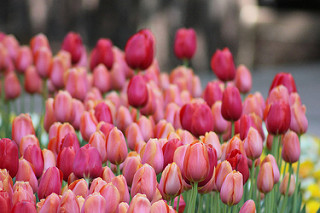

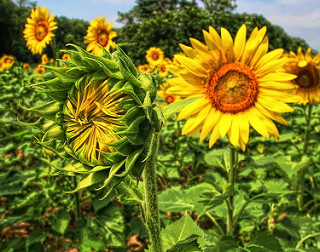

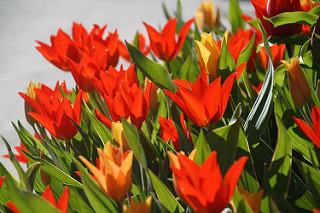

In [0]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [0]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10]) ###all_image_paths is built-in?

First 10 labels indices:  [1, 0, 2, 3, 3, 3, 1, 0, 1, 0]


### Create a train/test split

In [0]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

daisy


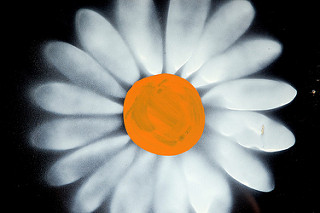


sunflowers


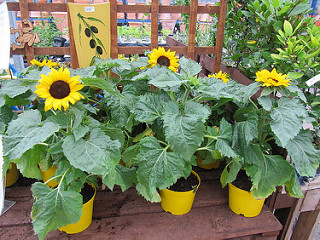


tulips


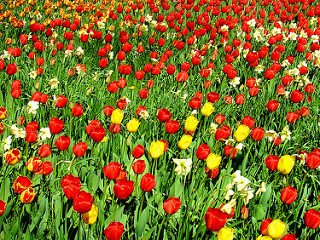

In [0]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [0]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x...


In [0]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)


(434, 500, 3)
<dtype: 'uint8'>


In [0]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
0.9998375


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [0]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize to [0,1] range
  return img

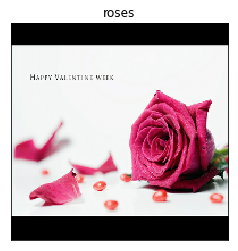

In [0]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]  ##why not the index?
show(img, label)

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit). 

In [0]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)##make the data fit in memory
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/4363734507_5cc4ed6e01.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/8717787983_c83bdf39fe_n.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/7166564830_8b34a3fd35_n.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/3664916269_29f07c7c7b.jpg', shape=(), dtype=string)


In [0]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE) ###calls?
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [0]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

roses
dandelion
tulips
dandelion


In [0]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [0]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) roses
(192, 192, 3) dandelion


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [0]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE) ##make every iteration different
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [0]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset

def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [0]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [0]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
15.77 Batches/s
504.78 Images/s
Total time: 5.451930999755859s


Now that the cache is built, iteration will be much faster.

In [0]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
174.63 Batches/s
5588.26 Images/s
Total time: 0.4924607276916504s


If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones).

In [0]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
### TODO: your code here
# Add another pair of Conv2d and MaxPoolin2dD layers
# As the depth of the network increases, the images
# become smaller, and you can afford to use more 
# filters in each layer
model.add(layers.Conv2D(64, (3, 3), activation = 'relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
#model.add(Activation('softmax'))


In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 64)        0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient the convolutional layers are than the dense ones.

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in Javascript in exactly the same way.

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 677125    
Total params: 696,517
Trainable params: 696,517
Non-trainable params: 0
________________________________________________

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# I realize we're using the test dataset (that's fine for this assignment)   ???? what should we use?
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
29/29 [==============================] - 11s 373ms/step - loss: 2.1770 - accuracy: 0.2658 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
29/29 [==============================] - 3s 92ms/step - loss: 1.3074 - accuracy: 0.4292 - val_loss: 1.0321 - val_accuracy: 0.5980
Epoch 3/5
29/29 [==============================] - 3s 88ms/step - loss: 1.0460 - accuracy: 0.5904 - val_loss: 0.8264 - val_accuracy: 0.7200
Epoch 4/5
29/29 [==============================] - 3s 86ms/step - loss: 0.7560 - accuracy: 0.7440 - val_loss: 0.5330 - val_accuracy: 0.8693
Epoch 5/5
29/29 [==============================] - 3s 89ms/step - loss: 0.4645 - accuracy: 0.8638 - val_loss: 0.2716 - val_accuracy: 0.9444


### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [0]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"
#########
im_batch = tf.expand_dims(img, 0) # to add 1 to make the input like a matrix

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction roses
Actual roses


### TODO: Improve accuracy
Write a new model that's more accurate than the baseline above (the baseline has only one Conv2D and MaxPooling2D layer). Produce plots of loss / accuracy as a function of epochs. Train your model without overfitting. For this assignment, it is not necessary to build a super accurate model - just experiment a bit and try to improve over the baseline.

In [0]:
# a new model here adding other layers
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Activation("relu"))
#model.add(layers.BatchNormalization(axis=chanDim))
#model.add(layers.Dropout(0.25))
 
		# increase the number of filters again, this time to 128
model.add(layers.Conv2D(128, (3, 3), padding="same"))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Activation("relu"))
#model.add(layers.BatchNormalization(axis=chanDim))

model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation("softmax"))
#model.add(BatchNormalization())



Epoch 1/5
29/29 [==============================] - 5s 161ms/step - loss: 2.2890 - accuracy: 0.2168 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
29/29 [==============================] - 3s 114ms/step - loss: 1.4957 - accuracy: 0.3475 - val_loss: 1.4712 - val_accuracy: 0.3486
Epoch 3/5
29/29 [==============================] - 3s 116ms/step - loss: 1.2858 - accuracy: 0.4510 - val_loss: 1.2719 - val_accuracy: 0.4771
Epoch 4/5
29/29 [==============================] - 3s 117ms/step - loss: 1.1939 - accuracy: 0.4804 - val_loss: 1.1768 - val_accuracy: 0.4651
Epoch 5/5
29/29 [==============================] - 3s 116ms/step - loss: 1.1118 - accuracy: 0.5349 - val_loss: 1.0465 - val_accuracy: 0.6068
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


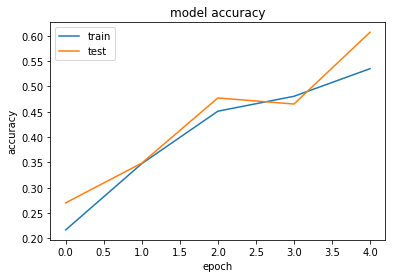

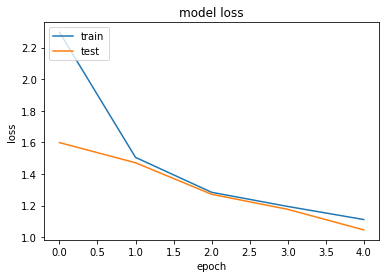

In [0]:
## plot the loss / accuracy of of epoch
# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Fit the model
history = model.fit(train_ds, validation_data=test_ds, epochs=5)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 1c) Try to get your flowers model working in TensorFlow.js
In the final part of the assignment, you'll export the model you build to recognize landmarks on Columbia's campus, and get it working in the browser. It's easiest to start by exporting your flowers model, and getting it working with TensorFlow.js (the starter code is build around your flowers model, so you can learn the mechanics before trying something more complex).

### Save your model

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

model.save("/content/gdrive/My Drive/my_model.h5")

In [0]:
!ls -lha

total 20K
drwxr-xr-x 1 root root 4.0K Oct 14 03:18 .
drwxr-xr-x 1 root root 4.0K Oct 14 01:04 ..
drwxr-xr-x 1 root root 4.0K Oct  8 20:06 .config
drwx------ 3 root root 4.0K Oct 14 03:18 gdrive
drwxr-xr-x 1 root root 4.0K Aug 27 16:17 sample_data


### Download it to your local machine

In [0]:
from google.colab import files
files.download("/content/gdrive/My Drive/my_model.h5")

### Visit notebook #2 to convert it to TensorFlow.js format
Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, continue with the rest of this assignment.

## 1d) Transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


References:
* https://www.tensorflow.org/beta/tutorials/images/transfer_learning

In [0]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 
IMG_SHAPE = (192, 192, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


In [0]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [0]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False 

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [0]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
29/29 [==============================] - 8s 283ms/step - loss: 1.2588 - accuracy: 0.5076 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
29/29 [==============================] - 4s 133ms/step - loss: 0.6693 - accuracy: 0.7745 - val_loss: 0.8298 - val_accuracy: 0.6797
Epoch 3/5
29/29 [==============================] - 4s 131ms/step - loss: 0.5092 - accuracy: 0.8399 - val_loss: 0.7593 - val_accuracy: 0.7190
Epoch 4/5
29/29 [==============================] - 4s 132ms/step - loss: 0.4191 - accuracy: 0.8638 - val_loss: 0.6325 - val_accuracy: 0.7778
Epoch 5/5
29/29 [==============================] - 4s 131ms/step - loss: 0.3785 - accuracy: 0.8780 - val_loss: 0.6200 - val_accuracy: 0.7669


## 2a) Recognize landmarks on Columbia's campus

In this part of the assignment, you will train a model to recognize landmarks (famous places, like the [Alma Mater sculpture](https://en.wikipedia.org/wiki/Alma_Mater_(New_York_sculpture), or Butler library) on Columbia’s campus. Instead of tf.data, you will gain experience with the higher level Keras utilties. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three landmarks. Your dataset should include at least 50 images of each landmark in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so, you can either upload it using the file browser (slow and tedious, you'll need to repeat that if your runtime is reset), or (better) you can upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`. As a another option, you could upload your dataset to a cloud provider or your Columbia account, then download it similarly to flowers at the top of this notebook.
 
1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning). 

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

### Data import
imort the photos I got from campus:
 - ALMA MATER sculpture
 - Lion 
 - The thinking man;

In [0]:
import os, shutil

In [5]:
!ls "/content/gdrive/My Drive/sculpture/"

'ALMA MATER'   LION   Thinker


In [0]:
### the path of different dataset
base_dir = '/content/gdrive/My Drive/scu_data/'
os.mkdir(base_dir)


In [0]:

## directory for training
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

## for each sculputure
##training
mater_train_dir = os.path.join(train_dir, 'mater')
os.mkdir(mater_train_dir)

lio_train_dir = os.path.join(train_dir,'lio')
os.mkdir(lio_train_dir)

thinker_train_dir = os.path.join(train_dir, 'thinker')
os.mkdir(thinker_train_dir)
##testing
mater_test_dir = os.path.join(test_dir, 'mater')
os.mkdir(mater_test_dir)

lio_test_dir = os.path.join(test_dir,'lio')
os.mkdir(lio_test_dir)

thinker_test_dir = os.path.join(test_dir, 'thinker')
os.mkdir(thinker_test_dir)
##validation
mater_val_dir = os.path.join(validation_dir, 'mater')
os.mkdir(mater_val_dir)

lio_val_dir = os.path.join(validation_dir,'lio')
os.mkdir(lio_val_dir)

thinker_val_dir = os.path.join(validation_dir, 'thinker')
os.mkdir(thinker_val_dir)



In [0]:
mater_dir = '/content/gdrive/My Drive/sculpture/ALMA MATER/'
lio_dir = '/content/gdrive/My Drive/sculpture/LION/'
think_dir = '/content/gdrive/My Drive/sculpture/Thinker/'

In [0]:
i = 0
for filename in os.listdir(mater_dir): 
        dst ="mater" + str(i) + ".jpg"
        src = mater_dir + filename 
        dst = mater_dir + dst 
          
        # rename() function will 
        # rename all the files 
        os.rename(src, dst) 
        i += 1
        
i = 0
for filename in os.listdir(lio_dir): 
        dst ="lio" + str(i) + ".jpg"
        src = lio_dir + filename 
        dst = lio_dir + dst 
          
        # rename() function will 
        # rename all the files 
        os.rename(src, dst) 
        i += 1
i = 0
for filename in os.listdir(think_dir): 
        dst ="think" + str(i) + ".jpg"
        src = think_dir + filename 
        dst = think_dir + dst 
          
        # rename() function will 
        # rename all the files 
        os.rename(src, dst) 
        i += 1

In [0]:
import random 
random.seed(50)

In [0]:
##copy images to the path we built
## training:
l = range(1,180)
sample1 = random.sample(l, k=92)

fnames = ['mater{}.jpg'.format(i) for i in sample1]
for fname in fnames:
    src = os.path.join(mater_dir, fname)
    dst = os.path.join(mater_train_dir, fname)
    shutil.copyfile(src, dst)

l = range(1,110)
sample2 = random.sample(l, k=55)

fnames = ['lio{}.jpg'.format(i) for i in sample2]
for fname in fnames:
  src = os.path.join(lio_dir, fname)
  dst = os.path.join(lio_train_dir, fname)
  shutil.copyfile(src,dst)
  
l = range(1,122)
sample3 = random.sample(l, k=62)

fnames = ['think{}.jpg'.format(i) for i in sample3]
for fname in fnames:
  src = os.path.join(think_dir, fname)
  dst = os.path.join(thinker_train_dir, fname)
  shutil.copyfile(src,dst)

In [0]:
vali1 = [i for i in range(182)]
for i in sample1:
  vali1.remove(i)
  
vali2 = [i for i in range(110)]
for i in sample2:
  vali2.remove(i)
  
vali3 = [i for i in range(122)]
for i in sample3:
  vali3.remove(i)

In [0]:
##copy images to the path we built
## validation:
fnames = ['mater{}.jpg'.format(i) for i in vali1] ##180
for fname in fnames:
    src = os.path.join(mater_dir, fname)
    dst = os.path.join(mater_val_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['lio{}.jpg'.format(i) for i in vali2] ##110
for fname in fnames:
  src = os.path.join(lio_dir, fname)
  dst = os.path.join(lio_val_dir, fname)
  shutil.copyfile(src,dst)
  

fnames = ['think{}.jpg'.format(i) for i in vali3]  ##122
for fname in fnames:
  src = os.path.join(think_dir, fname)
  dst = os.path.join(thinker_val_dir, fname)
  shutil.copyfile(src,dst)

### Data processing

In [44]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
      validation_dir,
      target_size = (150, 150),
      batch_size = 20
)

for data_batch, labels_batch in validation_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 310 images belonging to 3 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 3)
Found 205 images belonging to 3 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 3)


### Building the network

In [45]:
from keras import models, layers

Using TensorFlow backend.


In [0]:
model = models.Sequential()
model.add(layers.Cov2D(32, (3,3),activation = 'relu',
                      imput_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Cov2D(64, (3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Cov2D(128, (3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Cov2D(128, (3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [0]:
model.summary()

## 2b) Donate your dataset (optional)
We will use the dataset collected by the class later in the semester.

Requirements:

* Please do not include any images with people in the foreground.
* Only include images you have taken yourself and that you are comfortable sharing publicly under a [CCO](https://creativecommons.org/share-your-work/public-domain/cc0/) license (TLDR, public domain).

Link to upload a zip is on CourseWorks. Your file should be in the same format as the flowers dataset (the directory names gives the label for each image).



## 3) Run your model in the browser
Save and download your model, and head to notebook two again. After you've finished creating a webpage, upload it to GitHub pages or your Columbia account, list the URL here, and submit your assignment. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc.

In [0]:
# TODO: http://your_webpage